# Ejercicio análisis time series
Para este ejercicio vas a trabajar con el histórico de valores en bolsa de una empresa que se dedica a vender muebles. Se pide
1. Importa los datos 'df_furniture.csv'
2. Trata la fecha como texto. Crea una columna para el año, mes y dia, y a partir de esas columnas crea la de fecha, en formato datetime de pandas
3. ¿De qué fecha a qué fecha va el histórico?
4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?
5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?
6. Parece que hay una tendencia, pero no se aprecia bien con tanto pico en la serie. ¿Conoces algún método para representar mejor la tendencia?
7. Estaría bien visualizar todos los componentes de la serie temporal por separado
8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional
9. ¿Qué dependencia tiene cada instante de sus ultimos 5 lags? Demuéstralo mediante una matriz de correlación. ¿Esto es bueno para los modelos?
10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?
11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from warnings import filterwarnings
filterwarnings('ignore')

## 1. Cargamos los datos

In [255]:
df = pd.read_csv('data/df_furniture.csv')
df.head()

,Month,furniture_price_adjusted
0,1992-01-01,2073.432724
1,1992-02-01,2114.485812
2,1992-03-01,2260.570891
3,1992-04-01,2255.103236
4,1992-05-01,2331.414618


In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331 entries, 0 to 330
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Month                     326 non-null    object 
 1   furniture_price_adjusted  331 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.3+ KB


In [257]:
#Tratar valores nulos
print(df.isnull().sum())

Month                       5
furniture_price_adjusted    0
dtype: int64


In [258]:
df = df.interpolate('ffill')

## 2. Tratar la fecha como texto y parsear

In [259]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m-%d')

## 3. ¿De qué fecha a qué fecha va el histórico?

La serie va desde enero de 1992 a julio de 2019

In [260]:
print(f'El histórico va desde {df["Month"].min()} hasta {df["Month"].max()}')

El histórico va desde 1992-01-01 00:00:00 hasta 2019-07-01 00:00:00


## 4. ¿Cómo es la serie temporal? ¿Tiene tendencia? ¿Aprecias alguna estacionalidad?

Se ve que tiene una clara tendencia al alza, a pesar de una pequeña bajada en als acciones en el 2007.

También apreciamos estacionalidad, al cumplirse cierto patrón a lo largo del tiempo

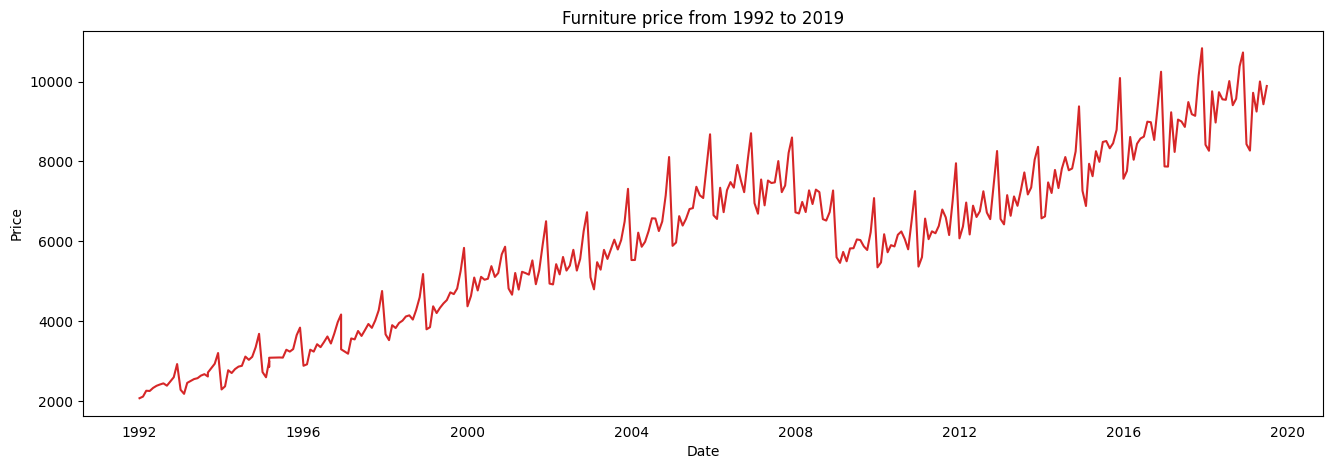

In [261]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Price', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.Month, y=df.furniture_price_adjusted, title='Furniture price from 1992 to 2019') 

## 5. ¿Podrías demostrar de dos maneras estadísticas que la serie no es stationary?

**Root Test Stationary**

La hipótesis nula de los test supone que la serie NO es estacionaria. Si el resultado del test queda por debajo del nivel de significación (0.05), rechazaremos la hipótesis nula en favor de la alternativa. En este caso, con un resultado de **0.7035529748089981** no se puede rechazar la hipótesis nula. Por lo tanto, la serie es NO estacionaria.

In [262]:
#Root Test Stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['furniture_price_adjusted'].values)
result[1]

0.7035529748089981

**Prueba de Kwiatkowski-Phillips-Schmidt-Shin (KPSS)**

Al contrario que el test anterior, la hipótesis nula del KPSS supone que la serie sí es estacionaria. Si el resultado del test queda por debajo del nivel de significación (0.05), rechazaremos la hipótesis nula en favor de la alternativa. En este caso, con un resultado de **0.01**, se rechaza la hipótesis nula. Por lo tanto, la serie es NO estacionaria.

In [263]:
from statsmodels.tsa.stattools import kpss

#Prueba
result = kpss(df['furniture_price_adjusted'].values)
result

(2.555246987562725,
 0.01,
 11,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [264]:
#Extracción del p value
print(f'P_value : {result[1]}')

P_value : 0.01


## 6. ¿Conoces algún método para representar mejor la tendencia?

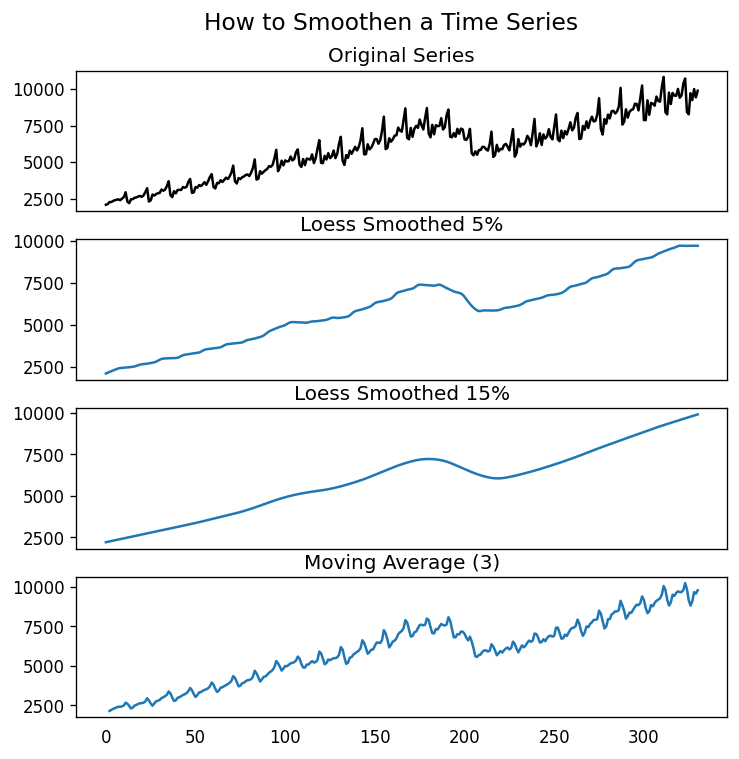

In [265]:
#Smoothing

from statsmodels.nonparametric.smoothers_lowess import lowess
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# 1. Moving Average
df_ma = df['furniture_price_adjusted'].rolling(3).mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df['furniture_price_adjusted'], np.arange(len(df['furniture_price_adjusted'])), frac=0.05)[:, 1], index=df.index, columns=['furniture_price_adjusted'])
df_loess_15 = pd.DataFrame(lowess(df['furniture_price_adjusted'], np.arange(len(df['furniture_price_adjusted'])), frac=0.15)[:, 1], index=df.index, columns=['furniture_price_adjusted'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df['furniture_price_adjusted'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['furniture_price_adjusted'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['furniture_price_adjusted'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

## 7. Estaría bien visualizar todos los componentes de la serie temporal por separado

Componentes de una serie temporal: trend, seasonality y Random/residuals.

In [266]:
df.index = df['Month']

In [267]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01'],
              dtype='datetime64[ns]', name='Month', length=331, freq=None)

In [272]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['furniture_price_adjusted'], model='multiplicative', extrapolate_trend='freq',period = 12)

# Additive Decomposition
result_add = seasonal_decompose(df['furniture_price_adjusted'], model='additive', extrapolate_trend='freq',period = 12)

# Plot
plt.rcParams.update({'figure.figsize': (6, 6)})

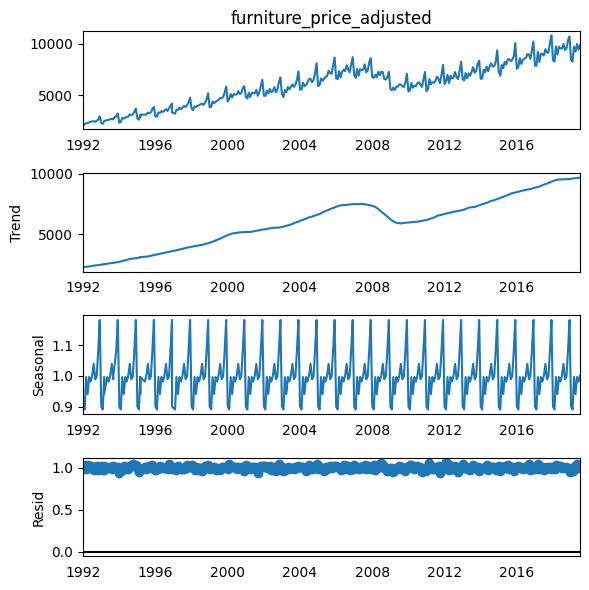

In [273]:
result_mul.plot();

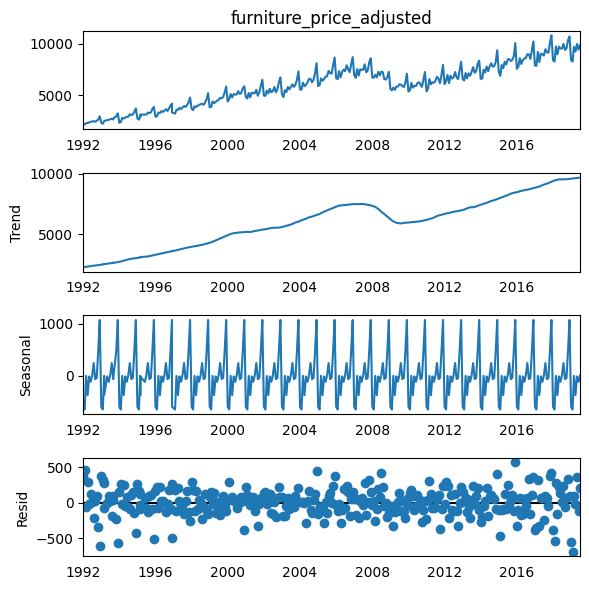

In [274]:
result_add.plot();

## 8. Demuestra mediante una gráfica de autocorrelación que la serie es estacional

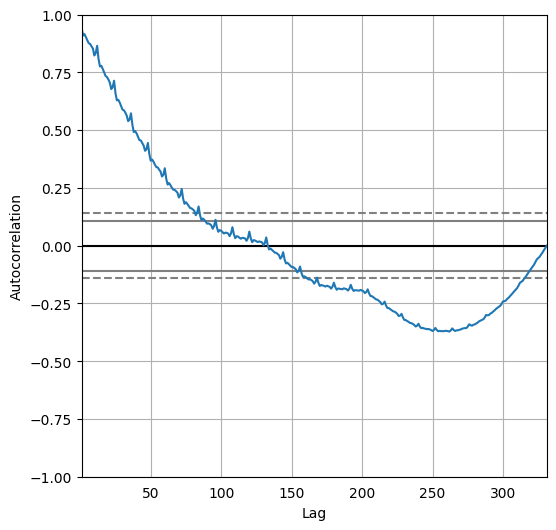

In [278]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df.furniture_price_adjusted.values);

## 9. ¿Qué dependencia tiene cada instante de sus ultimos 5 lags? Demuestralo mediante una matriz de correlación.

In [279]:
#Lista de columnas correspondientes a los últimos 5 lags
lag_columns = ['lag_{}'.format(i) for i in range(1, 6)]

# Crear columnas de lag en el DataFrame
for i, lag in enumerate(range(1, 6)):
    df['lag_{}'.format(lag)] = df['furniture_price_adjusted'].shift(lag)

# Seleccionar solo las columnas relevantes para la matriz de correlación
lag_df = df[lag_columns]

# Calcular la matriz de correlación
correlation_matrix = lag_df.corr()

# Mostrar la matriz de correlación
print(correlation_matrix)

          lag_1     lag_2     lag_3     lag_4     lag_5
lag_1  1.000000  0.950599  0.927538  0.944637  0.939980
lag_2  0.950599  1.000000  0.950224  0.926949  0.944155
lag_3  0.927538  0.950224  1.000000  0.949927  0.926156
lag_4  0.944637  0.926949  0.949927  1.000000  0.949554
lag_5  0.939980  0.944155  0.926156  0.949554  1.000000


## 10. Ya hemos visto que hay seasonality. ¿Cada cuántos instantes se cumple ese patrón?

Cada 12 instantes, según el gráfico de abajo.

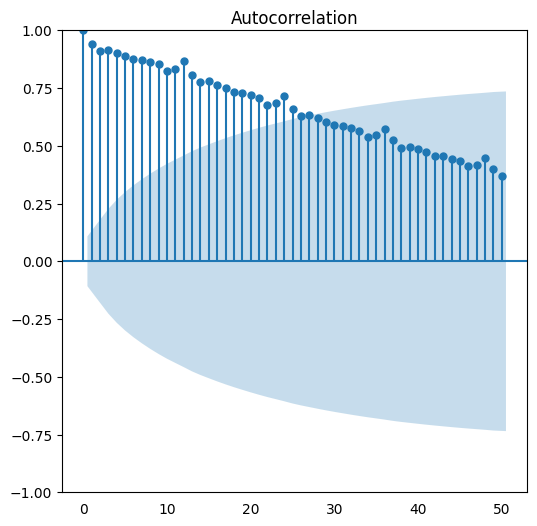

In [289]:
from statsmodels.graphics.tsaplots import plot_acf

# Calcular la autocorrelación de la serie
acf = plot_acf(df['furniture_price_adjusted'], lags=50)
plt.show();

## 11. Para un futuro modelado de los datos necesitaremos eliminar la tendencia. ¿Cómo hacemos esto?

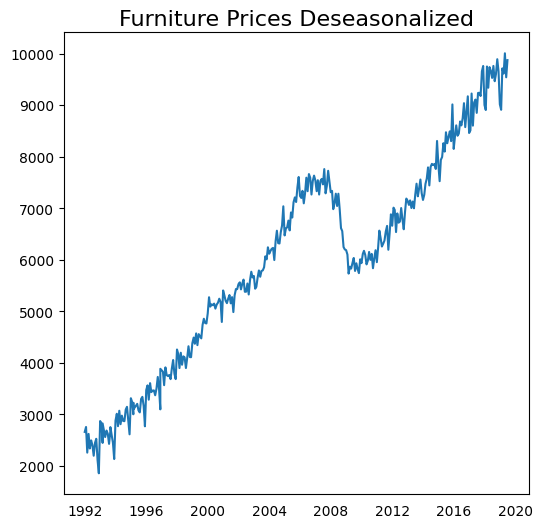

In [291]:
#Deseasonalize

# Time Series Decomposition
result_add = seasonal_decompose(df['furniture_price_adjusted'], model='additive', extrapolate_trend='freq',period = 12)

# Deseasonalize
deseasonalized = df.furniture_price_adjusted.values - result_add.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Furniture Prices Deseasonalized', fontsize=16);